# Part I Statistical Description of the Stock Price

In [1]:
#Load necessary packages
import pandas as pd
import numpy as np
import datetime
import pandas_datareader.data as web
from __future__ import division  
from sklearn import svm
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from collections import deque
import matplotlib.pyplot as plt

## Get basic infomation from Jan 1st 2015 to Dec 23rd 2016, including open price, highest price, lowest price, close price, trading volume and adjust close price.

In [2]:
start=datetime.date(2014,1,1)
end=datetime.date(2016,12,23)
Pufa=web.DataReader("600000.SS","yahoo",start,end)
Pufa_Stock=Pufa[(Pufa.Volume!=0)]
Pufa_Stock.head()    

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2014-01-02,9.44,9.45,9.29000,9.33000,76803100,7.22543
2014-01-03,9.28,9.30,9.08001,9.14000,97187100,7.07828
2014-01-06,9.31,9.34,9.13000,9.19001,128994400,7.11701
2014-01-07,9.17,9.21,9.01000,9.14000,79366000,7.07828
2014-01-08,9.14,9.32,9.11000,9.20000,86463800,7.12475


## Get the frequency of gong up and down and plot it 

In [3]:
#The frequency of going up and down
up_and_down=Pufa_Stock['Close']-Pufa_Stock['Open']>0
up_and_down_statistic=up_and_down.value_counts()
print(up_and_down_statistic)


True     349
False    346
dtype: int64


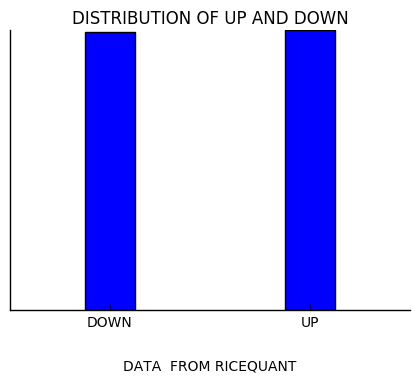

In [4]:
plt.figure()
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes((0.1, 0.2, 0.8, 0.7))
ax.bar([-0.125, 1.0-0.125], [up_and_down_statistic[0], 
                             up_and_down_statistic[1]], 0.25)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks([0, 1])
ax.set_xlim([-0.5, 1.5])
ax.set_ylim([0, up_and_down_statistic.max()])
ax.set_xticklabels(['DOWN', 'UP'])
plt.yticks([])
plt.title("DISTRIBUTION OF UP AND DOWN")
fig.text(0.5, 0.05,'DATA  FROM RICEQUANT',ha='center')
plt.show()

## Calculate the daily rate of  return and plot the distribution and density function of it

In [5]:
rate_of_return=(Pufa_Stock['Close']-Pufa_Stock['Open'])/Pufa_Stock['Open']
rate_of_return.describe()

count    695.000000
mean       0.001759
std        0.018449
min       -0.076092
25%       -0.006667
50%        0.000565
75%        0.009062
max        0.101336
dtype: float64

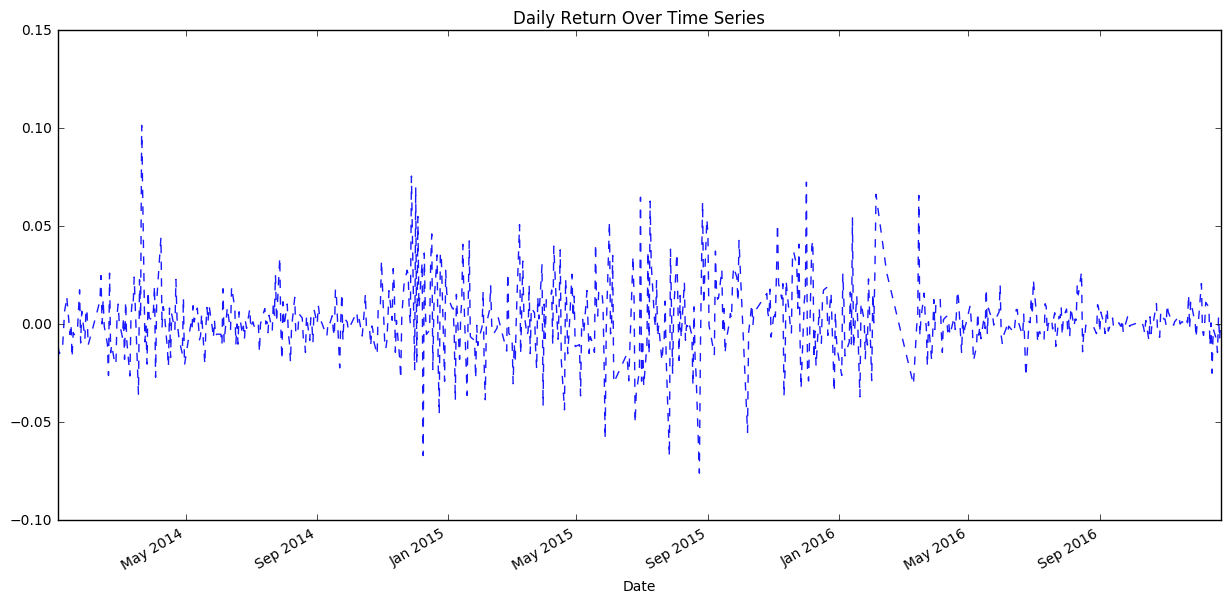

In [6]:
## Variation in the past decade
rate_of_return.plot(kind='line', style='b--',alpha=0.9, figsize=(15, 7),
                    title='Daily Return Over Time Series')
plt.show()

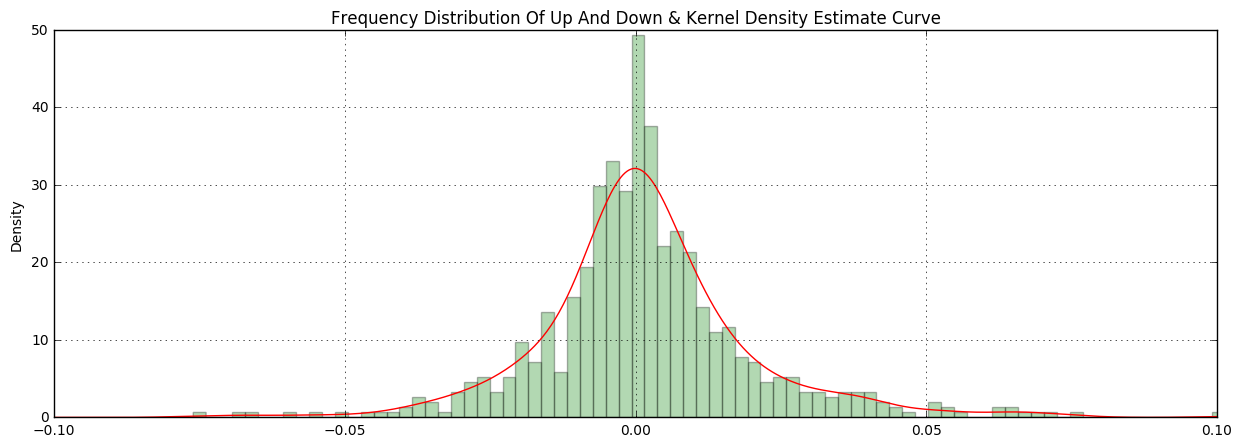

In [7]:
## Frequency distribution of up and down
rate_of_return.hist(bins=80, alpha=0.3, color='g', normed=True)
## Kernel Density Estimate,which is a standard distribution
rate_of_return.plot(kind='kde', xlim=[-0.1, 0.1], style='r', grid=True,
                    figsize=(15, 5), 
title='Frequency Distribution Of Up And Down & Kernel Density Estimate Curve')
plt.show()

# Part II Predict Stock Price by using Machine Learing Algorithm

## Step1: Choose the right model

Basically,there are two different machine learning algorithm: suprevised learning and unsupervised learning.The biggest difference between supervised learing and unsupervised learing is whether there is a specified tagert.
The supervised learning can be either classification or regression. Most of us are familiar with regression. Clasification is the kind of methods that ues samples belong to two or more classes and learn from already labeled data to predict the class of unlabeled data,such as Decision Tree, Naive Bayes, Linear SVC and etc.
Usally,its difficult to decide which method to use. However,according to the paper"Do we Need Hundreds of Classifiers to Solve Real World Classification Problems?" by Manuel Fernández-Delgado, Eva Cernadas, Senén Barro, Dinani Amorim(2014),in which they evaluate 179 classifiers arising from 17 families,including all the relevant classifiers available today. And result shows random forest and svm has the highest accuracy.
Thus,in this project wo will choose one of RandomForestClassifier,LinearSVC,KNeighborsClassifier to predict stock price trend.

As we need to decide which model perform better in predicting stock price, we need more stocks to complete this process.  Beside 600000.SH(Pufa Bank),we still add some other bank stocks,such as ICBC, CCB, CMBC and etc.

In [ ]:
stock_list = ['600000.SS', '600016.SS', '600036.SS','601998.SS', 
              '601166.SS',  '601818.SS','601398.SS',
              '601939.SS', '601288.SS', '601988.SS']

win_ratio1 = []
win_ratio2 = []
win_ratio3 = []

window=5
start=datetime.datetime(2014,1,1)
end=datetime.date(2015,12,31)

for stock in stock_list:
    df= web.DataReader(stock,"yahoo",start,end)
    df= df[(df.Volume!=0)]
    up_and_down = df['Close'] - df['Open'] > 0
        
    X = deque(maxlen = 100)
    y = deque(maxlen = 100)
    clf1 = RandomForestClassifier()
    clf2 = svm.LinearSVC()
    clf3 = neighbors.KNeighborsClassifier()
    prediction1 = 0
    prediction2 = 0
    prediction3 = 0

    test_num = 0
    win_num1 = 0
    win_num2 = 0
    win_num3 = 0

    current_index = 10
    for current_index in range(current_index, len(up_and_down)-1, 1):
        fact = up_and_down[current_index+1]
        
        X.append(list(up_and_down[(current_index-window): current_index]))
        y.append(up_and_down[current_index])
        if len(y) >= 100:
            test_num += 1
            clf1.fit(X, y)
            clf2.fit(X, y)
            clf3.fit(X, y)

            prediction1 = clf1.predict(list(up_and_down[(current_index-window+1): 
                                                        current_index+1]))
            prediction2 = clf2.predict(list(up_and_down[(current_index-window+1): 
                                                        current_index+1]))
            prediction3 = clf3.predict(list(up_and_down[(current_index-window+1): 
                                                        current_index+1]))

            if prediction1[0] == fact:
                win_num1 += 1
            if prediction2[0] == fact:
                win_num2 += 1
            if prediction3[0] == fact:
                win_num3 += 1
    win_ratio1.append(win_num1/test_num)
    win_ratio2.append(win_num2/test_num)
    win_ratio3.append(win_num3/test_num)

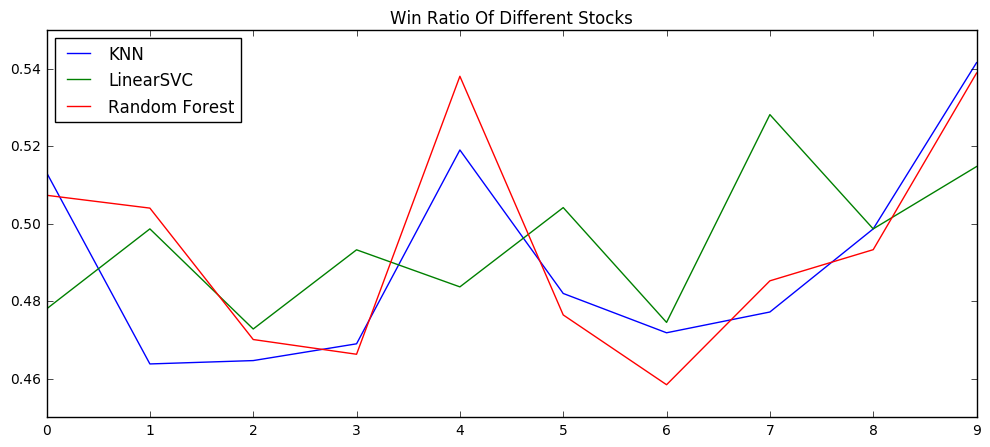

In [9]:
win_ratio123 = pd.DataFrame({'Random Forest' : win_ratio1, 
                             'LinearSVC' : win_ratio2, 
                             'KNN' : win_ratio3})
win_ratio123.plot(figsize=(12, 5), title='Win Ratio Of Different Stocks')
plt.show()

According to the picture above, random forest is better than the other algorithms, thus, we choose to use it for further prediction.

## Step2:Choose the number of samples for learning

In [ ]:
#This part we try to find the number of samples used to train the data set
import pandas as pd
import numpy as np
import datetime
from __future__ import division  
from sklearn.ensemble import RandomForestClassifier
from collections import deque
import matplotlib.pyplot as plt
import pandas_datareader.data as web

#import data
start=datetime.date(2015,1,1)
end=datetime.date(2016,12,23)
df=web.DataReader("600000.SS","yahoo",start,end)
df= df[(df.Volume!=0)]
up_and_down = df['Close'] - df['Open'] > 0
win_ratio2 = []


samples_list = [x for x in range(0,200,5) if x != 0]
window = 5
for samples in samples_list:
    clf = RandomForestClassifier()

    X = deque(maxlen = samples)
    y = deque(maxlen = samples)
    prediction = 0

    test_num = 0
    win_num = 0

    current_index = 200
    for current_index in range(current_index, len(up_and_down)-1, 1):
        fact = up_and_down[current_index+1]
        
        X.append(list(up_and_down[(current_index-window): current_index]))
        y.append(up_and_down[current_index])
        if len(y) >= samples:
            test_num += 1
            clf.fit(X, y)
            prediction = clf.predict(list(up_and_down[(current_index-window+1): 
                                                      current_index+1]))

            if prediction[0] == fact:
                win_num += 1

    win_ratio2.append(win_num/test_num)
fig = plt.figure(figsize=(15, 7))
plt.plot(samples_list, win_ratio2,'ro--')
plt.title('Win Ratio Of Different Number Of Training Samples')
plt.show()

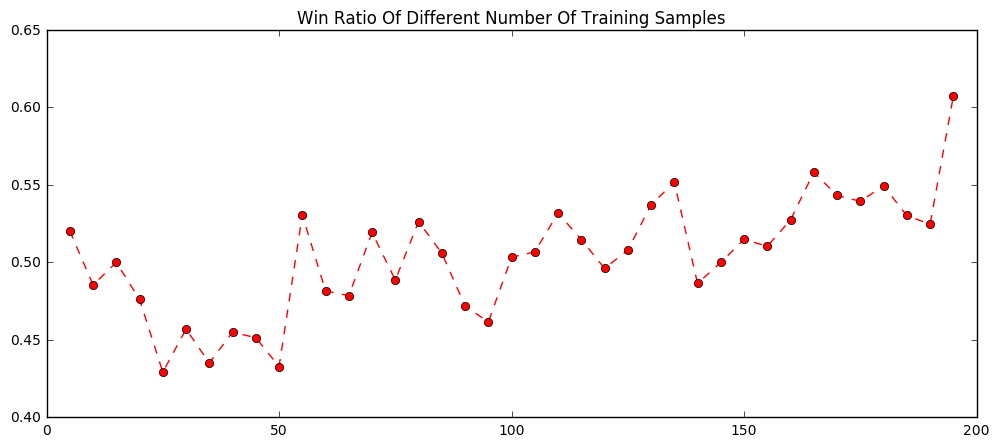

In [10]:
fig = plt.figure(figsize=(12, 5))
plt.plot(samples_list, win_ratio2,'ro--')
plt.title('Win Ratio Of Different Number Of Training Samples')
plt.show()

According to the line graph up , we can find when the number of samples increase, the accuracy will also rise. But our compuation source is limited ,thus ,we choose 150 groups of sample for learing.

## Step3: Find out the window to calculate the following trend of stock price 

In [ ]:
import pandas as pd
import numpy as np
import datetime
from sklearn.ensemble import RandomForestClassifier
from collections import deque
import matplotlib.pyplot as plt
import pandas_datareader.data as web

start=datetime.date(2015,1,1)
end=datetime.date(2016,12,23)
df=web.DataReader("600000.SS","yahoo",start,end)
df= df[(df.Volume!=0)]
up_and_down = df['Close'] - df['Open'] > 0
win_ratio = []

window_list = [x for x in range(15) if x != 0]

for window in window_list:
    clf = RandomForestClassifier()
    X = deque(maxlen = 160)
    y = deque(maxlen = 160)
    prediction = 0

    test_num = 0
    win_num = 0

    current_index = 30
    for current_index in range(current_index, len(up_and_down)-1, 1):
        fact = up_and_down[current_index+1]
        
        X.append(list(up_and_down[(current_index-window): current_index]))
        y.append(up_and_down[current_index])
        if len(y) >= 160 :
            test_num += 1
            clf.fit(X, y)

            prediction = clf.predict(list(up_and_down[(current_index-window+1):
                                                      current_index+1]))

            if prediction[0] == fact:
                win_num += 1

    win_ratio.append(win_num/test_num)

fig = plt.figure(figsize=(12, 5))
plt.plot(window_list, win_ratio, 'm')
plt.title('Win Ratio Of Different Time Window')
plt.show()

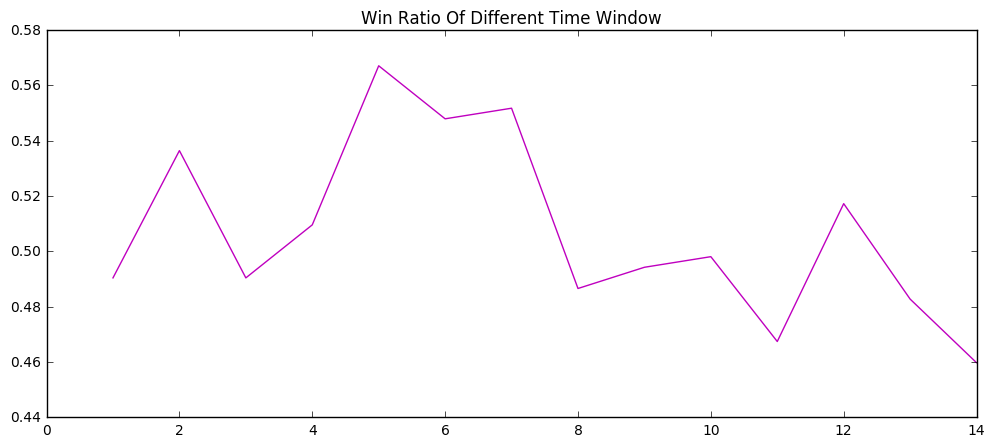

In [3]:
fig = plt.figure(figsize=(12, 5))
plt.plot(window_list, win_ratio, 'm')
plt.title('Win Ratio Of Different Time Window')
plt.show()


The picture above shows the relationship between accurarcy and the size of window, and when the window(also call the days of history data)is 5, we get the highest accurarcy.

# Part III Conclusion

For the analysis above, we should use the random forest to predict stock price, and the suitable number of 160, the window (days of historical data) should be 5.